# Practical Session: Reinforcement Learning

In this practical session, you will implement the [Value iteration and Policy iteration algorithms](https://www.ics.uci.edu/~dechter/publications/r42a-mdp_report.pdf) algorithm and test it in a reinforcement learning toy environment.

# OpenAI Gym

The [Gym library](https://www.google.com/search?client=firefox-b-d&q=openai+gym)  is a collection of test problems (or environments) developed by [OpenAI](https://openai.com/) sharing a standard interface.
This standard interface allows us to write general reinforcement learning algorithms and test them on several environments without many adaptations.

Gym's interface is straightforward.
Its core object is an **environment**, usually created with the instruction
```python
gym.make("ENV_NAME")
```
A gym environment has three key methods:
* `reset()`: this method reset the environment and return an observation of a random initial state
* `step(a)`: this method takes action `a` and returns three variables:
    * `observation`: the observation of the next state
    * `reward`: the reward obtained after transitioning from the previous state to the new one taking action `a`
    * `done`: a boolean indicating if an episode is finished
    * `info`: a variable used to pass any other kind of information
* `render()` this method renders the current state of the environment

## Frozen Lake

[Frozen lake](https://gym.openai.com/envs/FrozenLake-v0/) is an elementary "grid-world" environment provided in OpenAi Gym.
Starting from a non-changing initial position, you control an agent whose objective is to reach a goal located at the exact opposite of the map.
Some of the tiles are walkable, some other are holes ,and walking on them leads to the end of the episode. Due to the slipperiness of the frozen lake, some randomness is added in the transitions meaning that the movement direction of the agent is uncertain and only partially depends on the chosen direction.

Here is the official FrozenLake description provided by OpenAI:

*Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.*

*The surface is described using a grid like the following:*
```
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
```
*The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.*

Let's instantiate a FrozenLake environment:

In [1]:
pip install gymnasium

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

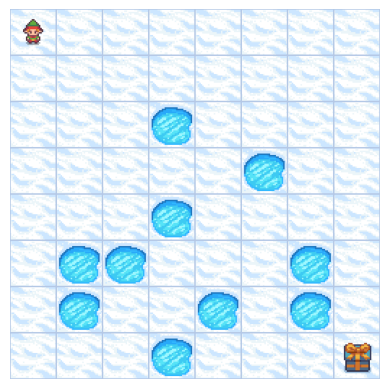

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
env = gym.make("FrozenLake8x8-v1", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.axis("off")

The environment provides informations about its Action and State Spaces

In [3]:
print(f"Action Space {env.action_space}")
print(f"State Space {env.observation_space}")

Action Space Discrete(4)
State Space Discrete(64)


The environment is composed of 64 discrete states corresponding to the agent's position on the grid.
The four possible actions are:

In [4]:
action_map = {0:u'\u2190', 1:u'\u2193', 2:u'\u2192', 3:u'\u2191'}
for k, v in action_map.items():
    print(f"action {k}: {v}")

action 0: ←
action 1: ↓
action 2: →
action 3: ↑


Use the ```step``` and ```render``` methods to observe the effect of the actions on the environment

(0, {'prob': 1})

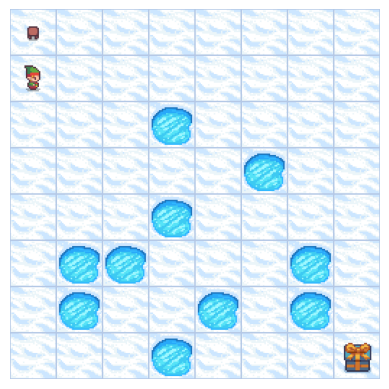

In [24]:
env.step(2)
plt.imshow(env.render())
plt.axis("off")
env.reset()

This function will help you to visualize our agent's trajectories:

In [25]:
import imageio
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import numpy as np

def display_trajectory(frames):
  imageio.mimwrite('./frozen_lake.gif',
                [np.array(frame) for i, frame in enumerate(frames)],
                fps=10)
  return(Image(open('frozen_lake.gif','rb').read()))


# Random agent

The following code shows you how to run an episode with an agent taking random actions.

action: ←
action: ↑
action: ↓
action: ↑
action: ↑
action: ↓
action: →
action: ↓
action: ↑
action: ↑
action: →
action: ←
action: →
action: ↑
action: ←
action: ←
action: ↑
action: ←
action: →
action: ←
action: →
action: ↓
action: ↓
action: ↓
action: ↑
action: ←
action: ↑
action: →
action: ←
action: →
action: ↑


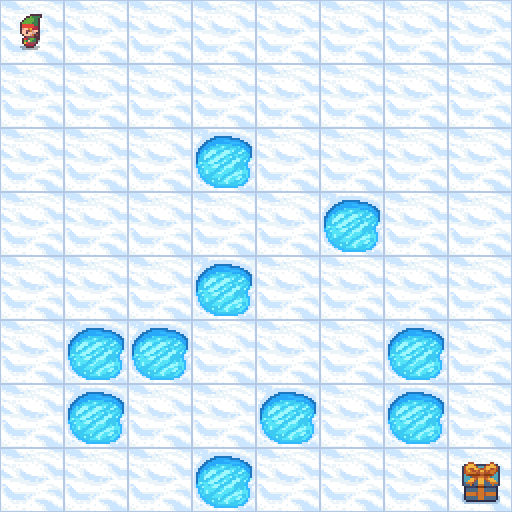

In [39]:
frames = [] # for animation
env.reset()
while True:
    # draw a random action from the action space
    action = env.action_space.sample()
    print(f"action: {action_map[action]}")
    # the step method takes an action as input and returns 4 variables described in the OpenAI section
    state, reward, done, terminated, info = env.step(action)
    frames.append(env.render())
    #if done is True then the episode is over
    if done:
        break

display_trajectory(frames)

## Human policy

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

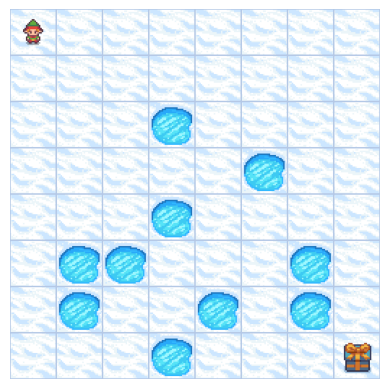

In [41]:
env.reset()
plt.imshow(env.render())
plt.axis("off")

We just saw a random policy. Let's now check on your policy.    
Using the possible actions, try to reach the goal by running multiple times the next cell.  
Reminder: action 0: ←
action 1: ↓
action 2: →
action 3: ↑

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

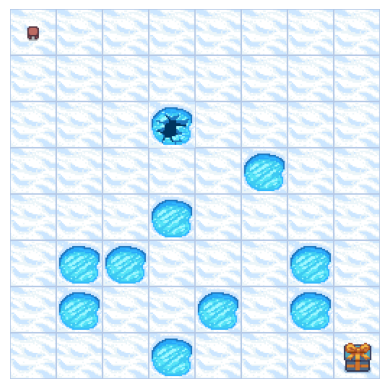

In [53]:
env.step(2)
plt.imshow(env.render())
plt.axis("off")

There are a few probabilities that you achieved the desired goal.
This is due to the stochasticity of the environment.
This environment provides an entire description of its transition model:

In [56]:
state = 0
env.unwrapped.P[state]


{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 8, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 8, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 8, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

Here you can see the transitions probabilities for every possible action.
For example, taking action 2 has:
* 33% chances to lead to state 8
* 33% chances to lead to state 1
* 33% chances to lead to state 0

Each line is composed as follow: (probability, next state, reward, end of episode)

# Policy iteration

Let's now try to solve the FrozenLake problem using the value policy algorithm.
![](https://github.com/DavidBert/N7-techno-IA/blob/master/code/reinforcement_learning/images/policy_iter.png?raw=1)

Fill the following code to implement the policy iteration algorithm:  
(hint:  ```env.unwrapped..P[s][a]``` returns a list  
$$[(p_1, s'_1, r_1, done)\\  
...\\
(p_n, s'_n, r_n, done)]$$
Iterate on this list to compute $\sum_{s',r}p(s',r|s,a)[r+\gamma V(s')]$)

In [ ]:
def compute_sum(env, V, s, a, gamma):
    # V is a list containing the estimated value for every state
    # len(V) = nb_states
    total = 0  # state value for state s
    for p, s_prime, r, _ in env.unwrapped..P[s][a]:
        ...
    return total

In [ ]:
import numpy as np

def policy_iteration(env, gamma, theta):
    nb_states = env.observation_space.n
    nb_actions = env.action_space.n
    # 1. Initialization
    V = np.zeros(nb_states)
    pi = np.zeros(nb_states)

    while True:

        # 2. Policy Evaluation
        while True:
            ...
        # 3. Policy Improvement
        policy_stable = True
        ...
            ...
        if policy_stable: break
    return V, pi

Run your algorithm on FrozenLake (you may use $\gamma=1$ and $\theta=1e-8$)

In [ ]:
V, pi = ...

Let's have a look at the computed values and policy

In [ ]:
import seaborn as sns
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(V.reshape([8, -1]), cmap="coolwarm", annot=True)
policy = np.array([action_map[x] for x in pi]).reshape([-1, 8])
print((policy))

You should see that the policy on state 55(tile (6,7)) and 62(tile (6,6)) appears different from the one we would expect.
Using ```env.unwrapped..P[s]``` to check the environment's transitions, can you explain this behavior and why state 55 has a low value?

In [ ]:
env.unwrapped..s = 62
plt.imshow(env.render())
plt.axis("off")

In [ ]:
...

# Value Iteration:

Let's now try to solve the FrozenLake problem using the value iteration algorithm.
![](https://github.com/DavidBert/N7-techno-IA/blob/master/code/reinforcement_learning/images/value_iteration.png?raw=1)

Fill the following code to implement the value iteration algorithm:  

In [ ]:
def value_iteration(env, gamma, theta):
    nb_states = env.observation_space.n
    nb_actions = env.action_space.n
    V = np.zeros(nb_states)

    while True:
        delta = 0
        ...
    # Output a deterministic policy
    pi = np.zeros(nb_states)
    for s in range(nb_states):
        pi[s] = ...

    return V, pi

Run your algorithm on FrozenLake (you may use $\gamma=1$ and $\theta=1e-8$)

In [ ]:
V, pi = ...

Let's have a look at the computed values and policy

In [ ]:
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(V.reshape([8, -1]), cmap="coolwarm", annot=True)
policy = np.array([action_map[x] for x in pi]).reshape([-1, 8])
print((policy))

In this practical session, we trained agents to solve the FrozenLake environment without ever interacting with it.
The Policy iteration and Value iteration algorithms are model-based algorithms. They can only be computed if we know the transitions probabilities used in the environment. This may not always be the case.
In the following practical session, you will train an RL agent by interacting with the environment using a model-free algorithm.